In [1]:
import numpy as np
import scipy as sp

from netrep.multiset import pairwise_distances, frechet_mean
from netrep.metrics import LinearMetric

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

/mnt/home/anejatbakhsh/anaconda3/envs/netrep/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper functions for generating a mean pringle shape and some noisy, rotated, and scaled shapes from it 

* First, a (mean) pringle shape in 3 dimensions is generated.
* Then noisy pringles are sampled which are rotated and scaled using random rotations and scales (either in 3 dimensions or higher dimensions).
* Then the frechet_mean function is run on the unaligned shapes using alpha = 0 or 1 (refer to the documentaion of alpha in LinearMetric class).
* Finally the inferred mean is aligned with the true mean using the same alpha to visualze the inferred mean.

In [2]:
# Generate a pringle shape in 3 dimensions
def generate_atlas(
        params={'a':1,'b':1,'radius':1},
        num_points=100
    ):
    # Generate points on a circle in the x-y plane
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = params['radius'] * np.cos(theta)
    y = params['radius'] * np.sin(theta)

    # Calculate the corresponding z values
    z = (x**2 / params['a']**2) - (y**2 / params['b']**2)

    return np.stack((x,y,z)).T


# Generate noisy samples from the pringle and rotate/scale them
def generate_point_clouds(
        mean,
        n_samples=10,
        d=3,
        noise_std=1e-3,
        scale_rng=[1,1]
    ):
    
    Xs = np.zeros((n_samples,len(mean),d))
    latent = np.zeros((n_samples,len(mean),mean.shape[1]))

    # Sample around each point in the mean
    for k in range(len(mean)):
        sample = sp.stats.multivariate_normal.rvs(
            mean=mean[k],
            cov=noise_std*np.eye(mean.shape[1]),
            size=n_samples
        )
        latent[:,k] = sample

    # Roatate sampled shapes
    for i in range(n_samples):
        R = sp.stats.ortho_group.rvs(d)[:,:mean.shape[1]].T
        scale = np.random.uniform(scale_rng[0],scale_rng[1])
        Xs[i] = scale*latent[i]@R
    
    return Xs


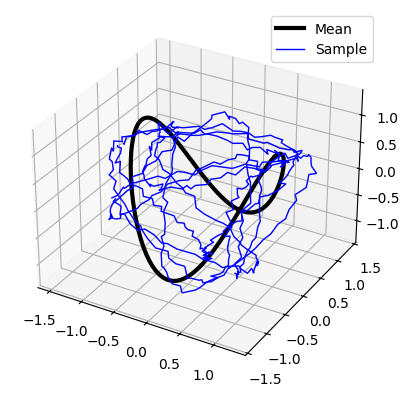

In [12]:

alpha = 0
mean = generate_atlas()
Xs = generate_point_clouds(
    mean,
    d=3,
    n_samples=5,
    scale_rng=[.9,1.1]
)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(
    mean[:,0], mean[:,1], mean[:,2], 
    color='k',label='Mean',lw=3
)

for i in range(len(Xs)):
    ax.plot(
        Xs[i][:,0], Xs[i][:,1], Xs[i][:,2], 
        color='b',lw=1,label='Sample' if i == 0 else None
    )

plt.legend()




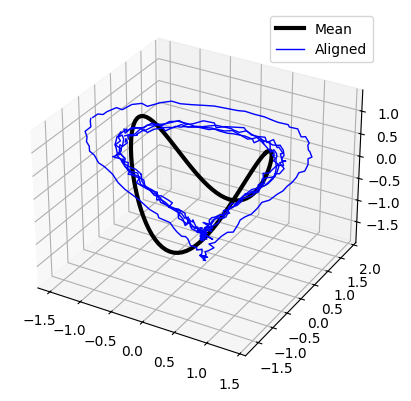

In [13]:
Xbar, aligned_Xs = frechet_mean(
    Xs, group='orth', 
    return_aligned_Xs=True,
    method='full_batch',
    alpha=alpha
)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.plot(
    mean[:,0], mean[:,1], mean[:,2], 
    color='k',label='Mean',lw=3
)

for i in range(len(Xs)):
    ax.plot(
        aligned_Xs[i][:,0], aligned_Xs[i][:,1], aligned_Xs[i][:,2], 
        color='b',lw=1,label='Aligned' if i == 0 else None
    )

plt.legend()




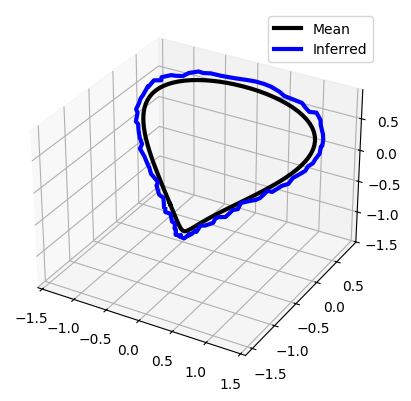

In [14]:
metric = LinearMetric(
    alpha=alpha,
    center_columns=True,
    score_method='euclidean',
)
metric.fit(mean,Xbar)
mean,Xbar=metric.transform(mean,Xbar)

          
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(
    mean[:,0], mean[:,1], mean[:,2], 
    color='k',label='Mean',lw=3
)

ax.plot(
    Xbar[:,0], Xbar[:,1], Xbar[:,2], 
    color='b',label='Inferred',lw=3
)
plt.legend()